In [5]:
import os
import pandas as pd
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ExponentialLR, CyclicLR
from torch.utils.data import Dataset, Subset, DataLoader
from torchvision import transforms, models
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, f1_score, classification_report
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import CyclicLR
from transformers import ViTModel, ViTConfig
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from tqdm import tqdm
from PIL import Image

# set the size of the image according to your model needs
imageSize = 224 # ResNet works with 224x224 pixels

# Custom Dataset
class BiomarkerDataset(Dataset):
    def __init__(self, label_file, transform=None, num_frames=0):
        """
        Args:
            label_file (str): Path to the CSV file.
            transform (callable, optional): Transform to be applied on a sample.
            num_frames (int): Number of adjacent frames to use in the input sequence (1 adjacent frame -> 3 consecutive images).
        """
        self.data = pd.read_csv(label_file)
        self.transform = transform
        self.num_frames = num_frames
        
        # Normalization
        self.bcva_mean = self.data.iloc[:, 19].mean()
        self.bcva_std = self.data.iloc[:, 19].std()
        self.cst_mean = self.data.iloc[:, 20].mean()
        self.cst_std = self.data.iloc[:, 20].std()

        
        # Exclude indices which don't have enough adjacent images
        self.valid_indices = self.data[(self.data.iloc[:, 1] > num_frames) & (self.data.iloc[:, 1] < (50-num_frames))].index.tolist()

    def __len__(self):
        # we can't use the length of the data since we have to exclude the first and last image (for num_frames=1) of each OCT scan
        return len(self.valid_indices)

    def __getitem__(self, idx):
        
        # Base path
        img_base_path = '/storage/ice1/shared/d-pace_community/makerspace-datasets/MEDICAL/OLIVES/OLIVES'
        
        # Get the actual data index
        index = self.valid_indices[idx]
        
        # Initialize
        images = []
        
        # Load a sequence of consecutive images
        for i in range(index - self.num_frames, index + self.num_frames +1):
            img_path = img_base_path + self.data.iloc[i, 0]
            img = Image.open(img_path).convert("L") # 'L' is for grayscale; can be removed!?
            
            if self.transform is not None:
                # apply data transformations (transforms it to tensor)
                img = self.transform(img)
            
            # stack torch tensor
            img = img.squeeze(0)  # Removes the first dimension if it's 1
            images.append(img)
        
        # Stack the 3 grayscale images along the channel dimension
        # Resulting tensor shape will be [3, H, W]
        images = torch.stack(images, dim=0)
        # print(images.shape) # debugging
        
        # Biomarker columns
        labels = torch.tensor(self.data.iloc[index, 2:18].astype(float), dtype=torch.float32)
        
        # Get clinical data:
        eye_id = self.data.iloc[index, 18]
        bcva = self.data.iloc[index, 19]
        cst = self.data.iloc[index, 20]
        patient_id = self.data.iloc[index, 21]
        
        # Normalize
        bcva = (bcva - self.bcva_mean) / self.bcva_std
        cst = (cst - self.cst_mean) / self.cst_std

        # Convert clinical data to tensor
        clinical_data = torch.tensor([eye_id, bcva, cst, patient_id], dtype=torch.float32)
        
        return images, labels, clinical_data
    
    
# Define transformers

# Values for normalization taken from example paper
mean = 0.1706
std = 0.2112

# Train transform with fixed resizing
train_transformer = transforms.Compose([
    transforms.Resize((224, 224)),  # Ensure fixed size of 224x224
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomRotation(degrees=10, fill=0),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

# Test transform with fixed resizing
test_transformer = transforms.Compose([
    transforms.Resize((224, 224)),  # Ensure fixed size of 224x224
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])


# set up train loader (just example since cross validation uses new ones)
train_dataset = BiomarkerDataset(label_file='TEMP_BiomarkerLabel_train_data.csv', transform=train_transformer, num_frames=1)
trainloader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4, drop_last=True, pin_memory=True)

# set up test loader (this one actually is being used)
test_dataset = BiomarkerDataset(label_file='TEMP_BiomarkerLabel_test_data.csv', transform=test_transformer, num_frames=1)
testloader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=16, pin_memory=True)



# --- Settings ---
num_epochs = 40
batch_size = 64
num_workers = 16  # Parallel data loading
k_folds = 5
patience = 8  # Early stopping patience

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- Dataset ---
class BiomarkerDataset(Dataset):
    def __init__(self, label_file, transform=None, num_frames=0, use_clinical=True):
        self.data = pd.read_csv(label_file)
        self.transform = transform
        self.num_frames = num_frames
        self.use_clinical = use_clinical
        self.valid_indices = self.data[
            (self.data.iloc[:, 1] > num_frames) & (self.data.iloc[:, 1] < (50 - num_frames))
        ].index.tolist()

    def __len__(self):
        return len(self.valid_indices)

    def __getitem__(self, idx):
        img_base_path = '/storage/ice1/shared/d-pace_community/makerspace-datasets/MEDICAL/OLIVES/OLIVES'
        index = self.valid_indices[idx]
        images = []

        for i in range(index - self.num_frames, index + self.num_frames + 1):
            img_path = os.path.join(img_base_path, self.data.iloc[i, 0])
            img = Image.open(img_path).convert("L")
            if self.transform is not None:
                img = self.transform(img)
            images.append(img.squeeze(0))

        images = torch.stack(images, dim=0)
        labels = torch.tensor(self.data.iloc[index, 2:16].astype(float), dtype=torch.float32)
        
        if self.use_clinical:
            clinical_data = torch.tensor(
                [self.data.iloc[index, 16], self.data.iloc[index, 17]], dtype=torch.float32
            )
        else:
            clinical_data = torch.tensor([], dtype=torch.float32)

        return images, labels, clinical_data


# --- ViT-Based Fusion Model ---
class FusionModelViT(nn.Module):
    def __init__(self, num_eyeID, num_patientID):
        super(FusionModelViT, self).__init__()

        # Vision Transformer as the image feature extractor
        vit_config = ViTConfig.from_pretrained("google/vit-base-patch16-224")
        self.image_model = ViTModel.from_pretrained("google/vit-base-patch16-224", config=vit_config)
        self.image_model.BackboneOutput = vit_config.hidden_size  # Should be 768

        # Embedding layers for categorical data
        self.patient_id_embedding = nn.Embedding(num_patientID, 16)
        self.eye_id_embedding = nn.Embedding(num_eyeID, 16)

        # Fully connected layers for numerical clinical data (e.g., BCVA, CST)
        self.clinical_fc = nn.Sequential(
            nn.Linear(2, 32),
            nn.ReLU(),
            nn.Dropout(0.1),
        )

        # Combine and compress all clinical data
        self.clinical_fusion_fc = nn.Sequential(
            nn.Linear(16 + 16 + 32, 32),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(32, 64),
        )

        # Final fusion layers
        self.fusion_fc = nn.Sequential(
            nn.Linear(self.image_model.BackboneOutput + 64, 16),  # Combine image and clinical features
        )

    def forward(self, images, clinical_data):
        # Extract features from images using ViT
        image_features = self.image_model(pixel_values=images).last_hidden_state[:, 0, :]  # CLS token features

        # Clinical data
        eye_id = clinical_data[:, 0].long()
        bcva = clinical_data[:, 1].view(-1, 1).float()
        cst = clinical_data[:, 2].view(-1, 1).float()
        patient_id = clinical_data[:, 3].long()

        # Embeddings for categorical clinical data
        eye_id_features = self.eye_id_embedding(eye_id).squeeze(1)
        patient_id_features = self.patient_id_embedding(patient_id).squeeze(1)

        # Numerical clinical data processing
        numerical_features = torch.cat([bcva, cst], dim=1)
        clinical_features = self.clinical_fc(numerical_features)

        # Combine all clinical features
        combined_clinical_features = torch.cat(
            [patient_id_features, eye_id_features, clinical_features], dim=1
        )
        fused_clinical_features = self.clinical_fusion_fc(combined_clinical_features)

        # Final fusion of image and clinical features
        fused_features = torch.cat([image_features, fused_clinical_features], dim=1)
        output = self.fusion_fc(fused_features)

        return output


# --- Initialize Model ---
num_eyeID = 100
num_patientID = 300
model = FusionModelViT(num_eyeID, num_patientID).to(device)
model.name = "FusionModelV2_ViTBase"

# --- Loss, Optimizer, Scheduler ---
loss_fn = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
schedulerBatch = CyclicLR(optimizer, base_lr=1e-5, max_lr=1e-3, step_size_up=2000, mode="triangular",cycle_momentum=False)


# --- Train/Test Loops ---
# Training loop
def train_loop(model, train_loader, optimizer, loss_fn, device):
    # Set model to train mode
    model.train()
    
    # Initialize
    running_loss = 0.0
    all_preds = []
    all_labels = []
    
    # for images, labels, _ in train_loader:
    for images, labels, clinical_data in tqdm(train_loader, desc="Training"):
        # shift to cuda
        images = images.to(device)
        labels = labels.to(device)
        clinical_data = clinical_data.to(device)
        
        # Zero the parameter gradients 
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(images, clinical_data)
        loss = loss_fn(outputs, labels)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        schedulerBatch.step() # CyclicLR after each batch
        
        # Track predictions and labels for metrics calculation
        running_loss += loss.item() * images.size(0)
        all_preds.append(outputs)
        all_labels.append(labels)
    
    # Average loss
    avg_loss = running_loss / len(train_loader.dataset)
    
    return avg_loss

# test loop
def test_loop(model, test_loader, loss_fn, device):
    # Set model to evaluation mode
    model.eval()
    
    # Initialize
    running_loss = 0.0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels, clinical_data in test_loader:
        # for images, labels, _ in tqdm(val_loader, desc="Validating"):
            # Store labels since they won't be altered
            # all_labels.append(labels.numpy())
            
            # Shift to cuda
            images = images.to(device)
            labels = labels.to(device)
            clinical_data = clinical_data.to(device)
        
            # Forward pass
            outputs = model(images, clinical_data)
            
            # Get metrics
            loss = loss_fn(outputs, labels)
            running_loss += loss.item() * images.size(0)
            
            # Sigmoid activation to get probabilities, then threshold at 0.5 for binary classification
            preds = torch.sigmoid(outputs) > 0.5 
            # preds = (torch.sigmoid(outputs) > 0.5).int()  # Apply sigmoid and threshold at 0.5

            # Store (numpy for easier processing later)
            all_preds.append(preds.cpu().numpy())
            all_labels.append(labels.cpu().numpy())

    # Calculate average loss
    avg_loss = running_loss / len(test_loader.dataset)

    # Convert lists of predictions and labels into a 2D array where each row is a sample, each column is a biomarker
    all_preds = np.concatenate(all_preds, axis=0)  # Shape: (num_samples, num_biomarkers)
    all_labels = np.concatenate(all_labels, axis=0)  # Shape: (num_samples, num_biomarkers)
    
    # Calculate F1 score for each biomarker (column) independently
#     f1_scores = []
#     for i in range(all_labels.shape[1]):  # Iterate over each biomarker
#         f1 = f1_score(all_labels[:, i], all_preds[:, i], average='binary')  # Compute F1 score for the ith biomarker
#         f1_scores.append(f1)

    # Average loss
    val_loss = running_loss / len(test_loader.dataset)
    # return val_loss, f1_scores, all_preds, all_labels
    return val_loss, all_preds, all_labels


# --- Cross-Validation ---

# Initialize object to split dataset in kfold
kfold = KFold(n_splits=k_folds, shuffle=True, random_state=0)

fold_metrics = []
    
for fold, (train_idx, val_idx) in enumerate(kfold.split(train_dataset)):
    print(f"Fold {fold+1}/{k_folds}")

    # Split the training dataset into training and validation folds
    train_fold = Subset(train_dataset, train_idx)
    val_fold = Subset(train_dataset, val_idx)
    
    # Set up Dataloaders
    train_loader = DataLoader(train_fold, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True)
    val_loader = DataLoader(val_fold, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)

    # Reset parameters
    best_val_loss = float('inf')
    best_val_f1 = 0.0
    counter_NoImprovement = 0

    for epoch in range(num_epochs):
    # for epoch in tqdm(range(num_epochs), desc="Training Epochs", unit="epoch"):
        print(f"Epoch {epoch+1}/{num_epochs}")

        # Train the model for one epoch
        train_loss = train_loop(model, train_loader, optimizer, loss_fn, device)
        print(f"Train Loss: {train_loss:.4f}")

        # Validate the model after training using validation fold
        val_loss, all_preds, all_labels = test_loop(model, val_loader, loss_fn, device)
        val_f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=0)
        print(f"Validation Loss: {val_loss:.4f}, Validation F1: {val_f1:.4f}")
        
        # Update learning rate
#         scheduler.step() # ExponentialLR after each epoch
        
        # Early stopping logic: Check if F1 improved
        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            counter_NoImprovement = 0  # Reset counter
            torch.save(model.state_dict(), f"ModelWeights_TempSaves/best_{model.name}_fold_{fold+1}.pth")
        else:
            counter_NoImprovement += 1

        # Stop training if no improvement for 'patience' epochs
        if counter_NoImprovement >= patience:
            print("Early stopping triggered.")
            counter_NoImprovement = 0
            break
        
#         # Save the best model based on validation loss
#         if val_loss < best_val_loss:
#             best_val_loss = val_loss
#             torch.save(model.state_dict(), f"ModelWeights_TempSaves/best_{model.name}_fold_{fold+1}.pth")

    # Load the weights of the model with the best validationg loss
    model.load_state_dict(torch.load(f"ModelWeights_TempSaves/best_{model.name}_fold_{fold+1}.pth", weights_only=True))
 
    # Get Accuracy
    # preds = (torch.sigmoid(torch.tensor(all_preds)) > 0.5).int()  # Apply sigmoid and threshold at 0.5
    val_accuracy = accuracy_score(all_labels, all_preds)
    fold_metrics.append(val_accuracy)
    print(f"Validation Accuracy for Fold {fold+1}: {val_accuracy:.4f}")

avg_accuracy = np.mean(fold_metrics)
print(f"\nAverage Accuracy over all folds: {avg_accuracy:.4f}")

Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Fold 1/5
Epoch 1/40


Training: 100%|██████████| 90/90 [00:06<00:00, 13.74it/s]


Train Loss: 0.3186
Validation Loss: 0.2343, Validation F1: 0.6131
Epoch 2/40


Training: 100%|██████████| 90/90 [00:06<00:00, 13.65it/s]

Train Loss: 0.2070


Validation Loss: 0.1923, Validation F1: 0.7330
Epoch 3/40


Training: 100%|██████████| 90/90 [00:06<00:00, 13.66it/s]

Train Loss: 0.1814


Validation Loss: 0.1729, Validation F1: 0.7769
Epoch 4/40


Training: 100%|██████████| 90/90 [00:06<00:00, 13.55it/s]

Train Loss: 0.1588


Validation Loss: 0.1564, Validation F1: 0.8104
Epoch 5/40


Training: 100%|██████████| 90/90 [00:06<00:00, 13.48it/s]

Train Loss: 0.1441


Validation Loss: 0.1471, Validation F1: 0.8154
Epoch 6/40


Training: 100%|██████████| 90/90 [00:06<00:00, 13.37it/s]

Train Loss: 0.1318


Validation Loss: 0.1377, Validation F1: 0.8210
Epoch 7/40


Training: 100%|██████████| 90/90 [00:06<00:00, 13.56it/s]

Train Loss: 0.1160


Validation Loss: 0.1298, Validation F1: 0.8418
Epoch 8/40


Training: 100%|██████████| 90/90 [00:06<00:00, 13.56it/s]


Train Loss: 0.1134
Validation Loss: 0.1250, Validation F1: 0.8465
Epoch 9/40


Training: 100%|██████████| 90/90 [00:06<00:00, 13.59it/s]

Train Loss: 0.1088


Validation Loss: 0.1257, Validation F1: 0.8534
Epoch 10/40


Training: 100%|██████████| 90/90 [00:06<00:00, 13.38it/s]

Train Loss: 0.1010


Validation Loss: 0.1240, Validation F1: 0.8522
Epoch 11/40


Training: 100%|██████████| 90/90 [00:06<00:00, 13.61it/s]

Train Loss: 0.0997


Validation Loss: 0.1200, Validation F1: 0.8575
Epoch 12/40


Training: 100%|██████████| 90/90 [00:06<00:00, 13.62it/s]

Train Loss: 0.1013


Validation Loss: 0.1155, Validation F1: 0.8630
Epoch 13/40


Training: 100%|██████████| 90/90 [00:06<00:00, 13.37it/s]

Train Loss: 0.0958


Validation Loss: 0.1145, Validation F1: 0.8693
Epoch 14/40


Training: 100%|██████████| 90/90 [00:06<00:00, 13.48it/s]

Train Loss: 0.0927


Validation Loss: 0.1119, Validation F1: 0.8651
Epoch 15/40


Training: 100%|██████████| 90/90 [00:06<00:00, 13.53it/s]

Train Loss: 0.0896


Validation Loss: 0.1419, Validation F1: 0.8412
Epoch 16/40


Training: 100%|██████████| 90/90 [00:06<00:00, 13.57it/s]

Train Loss: 0.1098


Validation Loss: 0.1207, Validation F1: 0.8643
Epoch 17/40


Training: 100%|██████████| 90/90 [00:06<00:00, 13.58it/s]


Train Loss: 0.0949
Validation Loss: 0.1248, Validation F1: 0.8498
Epoch 18/40


Training: 100%|██████████| 90/90 [00:06<00:00, 13.63it/s]

Train Loss: 0.0918


Validation Loss: 0.1116, Validation F1: 0.8745
Epoch 19/40


Training: 100%|██████████| 90/90 [00:06<00:00, 13.47it/s]


Train Loss: 0.0892
Validation Loss: 0.1100, Validation F1: 0.8731
Epoch 20/40


Training: 100%|██████████| 90/90 [00:06<00:00, 13.49it/s]

Train Loss: 0.0901


Validation Loss: 0.1080, Validation F1: 0.8746
Epoch 21/40


Training: 100%|██████████| 90/90 [00:06<00:00, 13.57it/s]


Train Loss: 0.0897
Validation Loss: 0.1169, Validation F1: 0.8613
Epoch 22/40


Training: 100%|██████████| 90/90 [00:06<00:00, 13.42it/s]

Train Loss: 0.0894


Validation Loss: 0.1169, Validation F1: 0.8702
Epoch 23/40


Training: 100%|██████████| 90/90 [00:06<00:00, 13.73it/s]


Train Loss: 0.0938
Validation Loss: 0.1150, Validation F1: 0.8696
Epoch 24/40


Training: 100%|██████████| 90/90 [00:06<00:00, 13.41it/s]

Train Loss: 0.0891


Validation Loss: 0.1105, Validation F1: 0.8729
Epoch 25/40


Training: 100%|██████████| 90/90 [00:06<00:00, 13.40it/s]

Train Loss: 0.0831


Validation Loss: 0.1137, Validation F1: 0.8652
Epoch 26/40


Training: 100%|██████████| 90/90 [00:06<00:00, 13.46it/s]


Train Loss: 0.0763
Validation Loss: 0.1147, Validation F1: 0.8745
Epoch 27/40


Training: 100%|██████████| 90/90 [00:06<00:00, 13.49it/s]

Train Loss: 0.0724


Validation Loss: 0.1072, Validation F1: 0.8814
Epoch 28/40


Training: 100%|██████████| 90/90 [00:06<00:00, 13.57it/s]

Train Loss: 0.0713


Validation Loss: 0.1024, Validation F1: 0.8853
Epoch 29/40


Training: 100%|██████████| 90/90 [00:06<00:00, 13.28it/s]

Train Loss: 0.0673


Validation Loss: 0.1063, Validation F1: 0.8800
Epoch 30/40


Training: 100%|██████████| 90/90 [00:06<00:00, 13.56it/s]

Train Loss: 0.0617


Validation Loss: 0.1026, Validation F1: 0.8857
Epoch 31/40


Training: 100%|██████████| 90/90 [00:06<00:00, 13.62it/s]

Train Loss: 0.0555


Validation Loss: 0.1002, Validation F1: 0.8950
Epoch 32/40


Training: 100%|██████████| 90/90 [00:06<00:00, 13.61it/s]

Train Loss: 0.0525


Validation Loss: 0.1042, Validation F1: 0.8954
Epoch 33/40


Training: 100%|██████████| 90/90 [00:06<00:00, 13.55it/s]

Train Loss: 0.0493


Validation Loss: 0.1031, Validation F1: 0.8963
Epoch 34/40


Training: 100%|██████████| 90/90 [00:06<00:00, 13.52it/s]

Train Loss: 0.0440


Validation Loss: 0.1045, Validation F1: 0.8974
Epoch 35/40


Training: 100%|██████████| 90/90 [00:06<00:00, 13.56it/s]

Train Loss: 0.0408


Validation Loss: 0.1081, Validation F1: 0.8998
Epoch 36/40


Training: 100%|██████████| 90/90 [00:06<00:00, 13.62it/s]

Train Loss: 0.0372


Validation Loss: 0.1130, Validation F1: 0.8972
Epoch 37/40


Training: 100%|██████████| 90/90 [00:06<00:00, 13.65it/s]

Train Loss: 0.0335


Validation Loss: 0.1149, Validation F1: 0.9010
Epoch 38/40


Training: 100%|██████████| 90/90 [00:06<00:00, 13.68it/s]

Train Loss: 0.0303


Validation Loss: 0.1118, Validation F1: 0.9027
Epoch 39/40


Training: 100%|██████████| 90/90 [00:06<00:00, 13.51it/s]

Train Loss: 0.0263


Validation Loss: 0.1149, Validation F1: 0.9031
Epoch 40/40


Training: 100%|██████████| 90/90 [00:06<00:00, 13.33it/s]

Train Loss: 0.0218


Validation Loss: 0.1230, Validation F1: 0.9032


/usr/local/lib/python3.10/dist-packages/torch/_utils.py:830: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


Validation Accuracy for Fold 1: 0.5731
Fold 2/5
Epoch 1/40


Training: 100%|██████████| 90/90 [00:06<00:00, 13.58it/s]

Train Loss: 0.0448


Validation Loss: 0.0248, Validation F1: 0.9702
Epoch 2/40


Training: 100%|██████████| 90/90 [00:06<00:00, 13.60it/s]

Train Loss: 0.0328


Validation Loss: 0.0229, Validation F1: 0.9732
Epoch 3/40


Training: 100%|██████████| 90/90 [00:06<00:00, 13.55it/s]


Train Loss: 0.0260
Validation Loss: 0.0230, Validation F1: 0.9720
Epoch 4/40


Training: 100%|██████████| 90/90 [00:06<00:00, 13.44it/s]

Train Loss: 0.0213


Validation Loss: 0.0225, Validation F1: 0.9741
Epoch 5/40


Training: 100%|██████████| 90/90 [00:06<00:00, 13.70it/s]

Train Loss: 0.0183


Validation Loss: 0.0222, Validation F1: 0.9716
Epoch 6/40


Training: 100%|██████████| 90/90 [00:06<00:00, 13.44it/s]

Train Loss: 0.0187


Validation Loss: 0.0229, Validation F1: 0.9725
Epoch 7/40


Training: 100%|██████████| 90/90 [00:06<00:00, 13.64it/s]

Train Loss: 0.0182


Validation Loss: 0.0245, Validation F1: 0.9709
Epoch 8/40


Training: 100%|██████████| 90/90 [00:06<00:00, 13.56it/s]

Train Loss: 0.0188


Validation Loss: 0.0300, Validation F1: 0.9640
Epoch 9/40


Training: 100%|██████████| 90/90 [00:06<00:00, 13.63it/s]

Train Loss: 0.0216


Validation Loss: 0.0333, Validation F1: 0.9572
Epoch 10/40


Training: 100%|██████████| 90/90 [00:06<00:00, 13.43it/s]

Train Loss: 0.0245


Validation Loss: 0.0382, Validation F1: 0.9533
Epoch 11/40


Training: 100%|██████████| 90/90 [00:06<00:00, 13.41it/s]

Train Loss: 0.0279


Validation Loss: 0.0436, Validation F1: 0.9463
Epoch 12/40


Training: 100%|██████████| 90/90 [00:06<00:00, 13.44it/s]

Train Loss: 0.0322


Validation Loss: 0.0440, Validation F1: 0.9462
Early stopping triggered.
Validation Accuracy for Fold 2: 0.7488
Fold 3/5
Epoch 1/40


Training: 100%|██████████| 90/90 [00:06<00:00, 13.48it/s]

Train Loss: 0.0422


Validation Loss: 0.0400, Validation F1: 0.9539
Epoch 2/40


Training: 100%|██████████| 90/90 [00:06<00:00, 13.50it/s]


Train Loss: 0.0442
Validation Loss: 0.0509, Validation F1: 0.9378
Epoch 3/40


Training: 100%|██████████| 90/90 [00:06<00:00, 13.38it/s]


Train Loss: 0.0462
Validation Loss: 0.0550, Validation F1: 0.9349
Epoch 4/40


Training: 100%|██████████| 90/90 [00:06<00:00, 13.43it/s]

Train Loss: 0.0494


Validation Loss: 0.0596, Validation F1: 0.9284
Epoch 5/40


Training: 100%|██████████| 90/90 [00:06<00:00, 13.42it/s]

Train Loss: 0.0484


Validation Loss: 0.0663, Validation F1: 0.9192
Epoch 6/40


Training: 100%|██████████| 90/90 [00:06<00:00, 13.61it/s]

Train Loss: 0.0540


Validation Loss: 0.0708, Validation F1: 0.9158
Epoch 7/40


Training: 100%|██████████| 90/90 [00:06<00:00, 13.50it/s]

Train Loss: 0.0532


Validation Loss: 0.0831, Validation F1: 0.9012
Epoch 8/40


Training: 100%|██████████| 90/90 [00:06<00:00, 13.55it/s]


Train Loss: 0.0571
Validation Loss: 0.0800, Validation F1: 0.9065
Epoch 9/40


Training: 100%|██████████| 90/90 [00:06<00:00, 13.58it/s]

Train Loss: 0.0599


Validation Loss: 0.0866, Validation F1: 0.9026
Early stopping triggered.
Validation Accuracy for Fold 3: 0.5892
Fold 4/5
Epoch 1/40


Training: 100%|██████████| 90/90 [00:06<00:00, 13.48it/s]


Train Loss: 0.0736
Validation Loss: 0.0797, Validation F1: 0.9080
Epoch 2/40


Training: 100%|██████████| 90/90 [00:06<00:00, 13.49it/s]


Train Loss: 0.0805
Validation Loss: 0.0808, Validation F1: 0.9054
Epoch 3/40


Training: 100%|██████████| 90/90 [00:06<00:00, 13.42it/s]

Train Loss: 0.0804


Validation Loss: 0.0784, Validation F1: 0.9086
Epoch 4/40


Training: 100%|██████████| 90/90 [00:06<00:00, 13.56it/s]

Train Loss: 0.0755


Validation Loss: 0.0872, Validation F1: 0.8964
Epoch 5/40


Training: 100%|██████████| 90/90 [00:06<00:00, 13.46it/s]

Train Loss: 0.0806


Validation Loss: 0.0941, Validation F1: 0.8914
Epoch 6/40


Training: 100%|██████████| 90/90 [00:06<00:00, 13.61it/s]

Train Loss: 0.0845


Validation Loss: 0.0971, Validation F1: 0.8877
Epoch 7/40


Training: 100%|██████████| 90/90 [00:06<00:00, 13.58it/s]


Train Loss: 0.0761
Validation Loss: 0.0941, Validation F1: 0.8891
Epoch 8/40


Training: 100%|██████████| 90/90 [00:06<00:00, 13.61it/s]

Train Loss: 0.0709


Validation Loss: 0.0942, Validation F1: 0.8959
Epoch 9/40


Training: 100%|██████████| 90/90 [00:06<00:00, 13.36it/s]

Train Loss: 0.0669


Validation Loss: 0.0895, Validation F1: 0.8969
Epoch 10/40


Training: 100%|██████████| 90/90 [00:06<00:00, 13.56it/s]

Train Loss: 0.0638


Validation Loss: 0.0947, Validation F1: 0.8914
Epoch 11/40


Training: 100%|██████████| 90/90 [00:06<00:00, 13.63it/s]


Train Loss: 0.0574
Validation Loss: 0.0934, Validation F1: 0.8985
Early stopping triggered.
Validation Accuracy for Fold 4: 0.5710
Fold 5/5
Epoch 1/40


Training: 100%|██████████| 90/90 [00:06<00:00, 13.54it/s]

Train Loss: 0.0693


Validation Loss: 0.0711, Validation F1: 0.9145
Epoch 2/40


Training: 100%|██████████| 90/90 [00:06<00:00, 13.67it/s]

Train Loss: 0.0643


Validation Loss: 0.0647, Validation F1: 0.9220
Epoch 3/40


Training: 100%|██████████| 90/90 [00:06<00:00, 13.63it/s]

Train Loss: 0.0532


Validation Loss: 0.0659, Validation F1: 0.9251
Epoch 4/40


Training: 100%|██████████| 90/90 [00:06<00:00, 13.08it/s]

Train Loss: 0.0499


Validation Loss: 0.0681, Validation F1: 0.9160
Epoch 5/40


Training: 100%|██████████| 90/90 [00:06<00:00, 13.51it/s]

Train Loss: 0.0480


Validation Loss: 0.0660, Validation F1: 0.9236
Epoch 6/40


Training: 100%|██████████| 90/90 [00:06<00:00, 13.42it/s]

Train Loss: 0.0426


Validation Loss: 0.0684, Validation F1: 0.9180
Epoch 7/40


Training: 100%|██████████| 90/90 [00:06<00:00, 13.43it/s]

Train Loss: 0.0369


Validation Loss: 0.0625, Validation F1: 0.9279
Epoch 8/40


Training: 100%|██████████| 90/90 [00:06<00:00, 13.51it/s]

Train Loss: 0.0322


Validation Loss: 0.0626, Validation F1: 0.9273
Epoch 9/40


Training: 100%|██████████| 90/90 [00:06<00:00, 13.46it/s]

Train Loss: 0.0274


Validation Loss: 0.0676, Validation F1: 0.9259
Epoch 10/40


Training: 100%|██████████| 90/90 [00:06<00:00, 13.36it/s]

Train Loss: 0.0241


Validation Loss: 0.0723, Validation F1: 0.9218
Epoch 11/40


Training: 100%|██████████| 90/90 [00:06<00:00, 13.30it/s]

Train Loss: 0.0210


Validation Loss: 0.0696, Validation F1: 0.9262
Epoch 12/40


Training: 100%|██████████| 90/90 [00:06<00:00, 13.58it/s]

Train Loss: 0.0173


Validation Loss: 0.0689, Validation F1: 0.9291
Epoch 13/40


Training: 100%|██████████| 90/90 [00:06<00:00, 13.62it/s]

Train Loss: 0.0142


Validation Loss: 0.0731, Validation F1: 0.9298
Epoch 14/40


Training: 100%|██████████| 90/90 [00:06<00:00, 13.57it/s]

Train Loss: 0.0109


Validation Loss: 0.0738, Validation F1: 0.9287
Epoch 15/40


Training: 100%|██████████| 90/90 [00:06<00:00, 13.56it/s]

Train Loss: 0.0087


Validation Loss: 0.0767, Validation F1: 0.9287
Epoch 16/40


Training: 100%|██████████| 90/90 [00:06<00:00, 13.56it/s]

Train Loss: 0.0071


Validation Loss: 0.0793, Validation F1: 0.9292
Epoch 17/40


Training: 100%|██████████| 90/90 [00:06<00:00, 13.67it/s]

Train Loss: 0.0061


Validation Loss: 0.0781, Validation F1: 0.9278
Epoch 18/40


Training: 100%|██████████| 90/90 [00:06<00:00, 13.61it/s]


Train Loss: 0.0052
Validation Loss: 0.0765, Validation F1: 0.9306
Epoch 19/40


Training: 100%|██████████| 90/90 [00:06<00:00, 13.69it/s]

Train Loss: 0.0057


Validation Loss: 0.0796, Validation F1: 0.9289
Epoch 20/40


Training: 100%|██████████| 90/90 [00:06<00:00, 13.39it/s]

Train Loss: 0.0059


Validation Loss: 0.0832, Validation F1: 0.9280
Epoch 21/40


Training: 100%|██████████| 90/90 [00:06<00:00, 13.58it/s]

Train Loss: 0.0071


Validation Loss: 0.0858, Validation F1: 0.9274
Epoch 22/40


Training: 100%|██████████| 90/90 [00:06<00:00, 13.57it/s]

Train Loss: 0.0103


Validation Loss: 0.0830, Validation F1: 0.9280
Epoch 23/40


Training: 100%|██████████| 90/90 [00:06<00:00, 13.42it/s]

Train Loss: 0.0158


Validation Loss: 0.0861, Validation F1: 0.9239
Epoch 24/40


Training: 100%|██████████| 90/90 [00:06<00:00, 13.43it/s]

Train Loss: 0.0217


Validation Loss: 0.0891, Validation F1: 0.9182
Epoch 25/40


Training: 100%|██████████| 90/90 [00:06<00:00, 13.49it/s]

Train Loss: 0.0223


Validation Loss: 0.0863, Validation F1: 0.9186
Epoch 26/40


Training: 100%|██████████| 90/90 [00:06<00:00, 13.63it/s]

Train Loss: 0.0276


Validation Loss: 0.0855, Validation F1: 0.9168
Early stopping triggered.
Validation Accuracy for Fold 5: 0.6366

Average Accuracy over all folds: 0.6237


In [6]:
# ============================
# 5. Evaluation
# ============================

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def evaluate_model(model, loader):
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for batch in tqdm(loader, desc="Evaluating", unit="batch"):
            if not batch:  # Handle empty batches
                continue
            images, labels, clinical_data = batch
            images, labels, clinical_data = images.to(device), labels.to(device), clinical_data.to(device)
            outputs = model(images,clinical_data) # .logits
            y_true.append(labels.cpu().numpy())
            y_pred.append(outputs.cpu().numpy())
    y_true = np.vstack(y_true)
    y_pred = np.vstack(y_pred)
    return y_true, y_pred

# Evaluate
y_true, y_pred = evaluate_model(model, testloader)

# Convert predicted probabilities to binary predictions
y_pred_binary = (sigmoid(y_pred) > 0.5).astype(int)
# y_pred_binary = (y_pred > 0.5).astype(int)

# Ensure `y_true` is binary
y_true_binary = (y_true > 0.5).astype(int)

# Metrics
report = classification_report(y_true_binary, y_pred_binary,zero_division=0)
report_data = classification_report(y_true_binary, y_pred_binary, output_dict=True,zero_division=0) # this is not clean to print but easier to extract
weighted_f1 = report_data['weighted avg']['f1-score']
samples_f1 = report_data['samples avg']['f1-score']
print("Classification Report:")
print(report)

# Store the predicitons in a csv file
# get the biomarker names
BiomarkerLabel_df = pd.read_csv('TEMP_BiomarkerLabel_train_data.csv')
biomarkers = BiomarkerLabel_df.columns[2:18] # Extract label columns names (biomarkers)

# Convert the predictions into a pandas DataFrame with biomarker names as columns
df_predictions = pd.DataFrame(y_pred_binary, columns=biomarkers)

# Add the "Index" name (as the row index)
df_predictions.insert(0, "Index", df_predictions.index.to_series().apply(lambda x: f"{x+1:04d}"))

# Save the DataFrame to a CSV file
df_predictions.to_csv("predictions_biomarkers.csv",  index=False)

Evaluating: 100%|██████████| 30/30 [00:02<00:00, 10.95batch/s]

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        89
           1       0.06      0.03      0.04        72
           2       0.00      0.00      0.00         3
           3       0.00      0.00      0.00        76
           4       0.84      0.75      0.80      1443
           5       0.53      0.48      0.51       746
           6       0.62      0.67      0.65       950
           7       0.35      0.07      0.11       104
           8       0.54      0.38      0.45       606
           9       0.00      0.00      0.00         3
          10       0.91      0.76      0.83       645
          11       0.88      0.66      0.75       954
          12       0.50      0.17      0.26        52
          13       0.00      0.00      0.00         1
          14       0.00      0.00      0.00         0
          15       0.00      0.00      0.00        19

   micro avg       0.72      0.60      0.66      5763
   

Evaluating Model with Clinical Data...
Evaluating Scan-Level Metrics...
Plotting Combined Confusion Matrix for Scan-Level Predictions...


<Figure size 600x400 with 0 Axes>

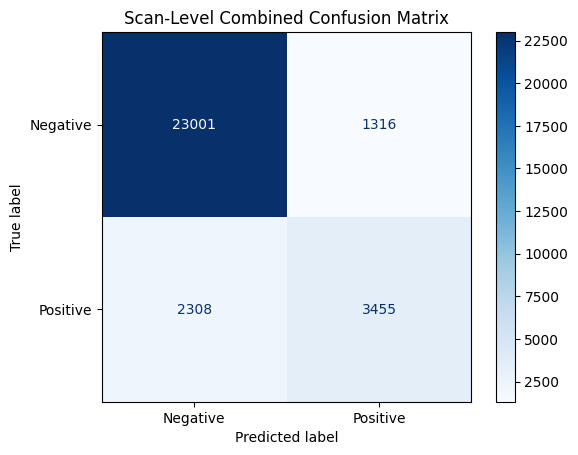

                           Biomarker       AUC  Precision    Recall        F1
0                            Atrophy  0.689120   0.000000  0.000000  0.000000
1                   Disruption of EZ  0.705599   0.057143  0.027778  0.037383
2                               DRIL  0.090570   0.000000  0.000000  0.000000
3                     IR hemorrhages  0.700804   0.000000  0.000000  0.000000
4                             IR HRF  0.740956   0.844841  0.754678  0.797218
5   Partially attached vitreous face  0.643527   0.534024  0.483914  0.507736
6       Fully attached vitreous face  0.675820   0.619555  0.673684  0.645487
7       Preretinal tissue/hemorrhage  0.736801   0.350000  0.067308  0.112903
8                    Vitreous debris  0.666586   0.535797  0.382838  0.446583
9                                VMT  0.804653   0.000000  0.000000  0.000000
10                            DRT/ME  0.949917   0.910448  0.756589  0.826418
11                       Fluid (IRF)  0.847028   0.881857  0.657

<Figure size 600x400 with 0 Axes>

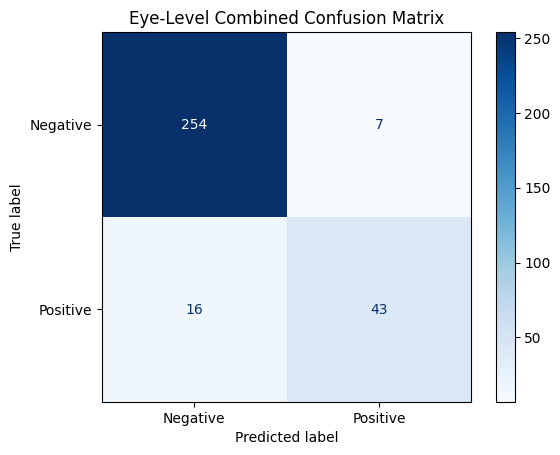

                           Biomarker       AUC  Precision    Recall        F1
0                            Atrophy  0.684211   0.000000  0.000000  0.000000
1                   Disruption of EZ       NaN   0.000000  0.000000  0.000000
2                               DRIL       NaN   0.000000  0.000000  0.000000
3                     IR hemorrhages       NaN   0.000000  0.000000  0.000000
4                             IR HRF  0.947368   1.000000  0.947368  0.972973
5   Partially attached vitreous face  0.659341   0.571429  0.571429  0.571429
6       Fully attached vitreous face  0.780000   0.636364  0.700000  0.666667
7       Preretinal tissue/hemorrhage  1.000000   0.000000  0.000000  0.000000
8                    Vitreous debris  0.745098   1.000000  0.333333  0.500000
9                                VMT       NaN   0.000000  0.000000  0.000000
10                            DRT/ME  1.000000   1.000000  0.833333  0.909091
11                       Fluid (IRF)  0.927083   1.000000  0.666

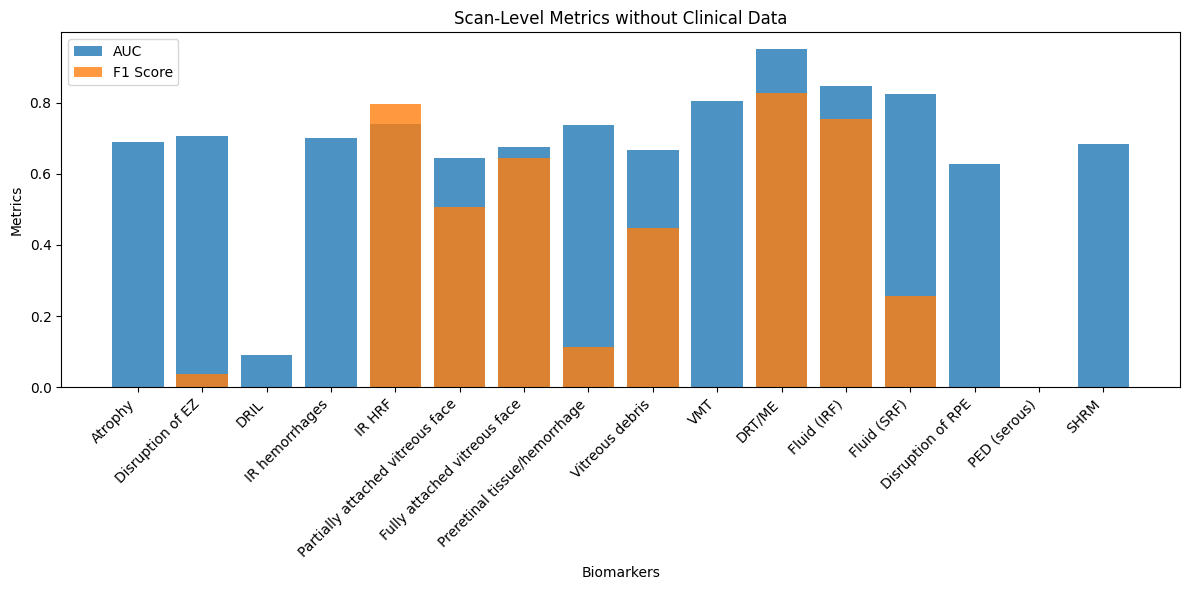

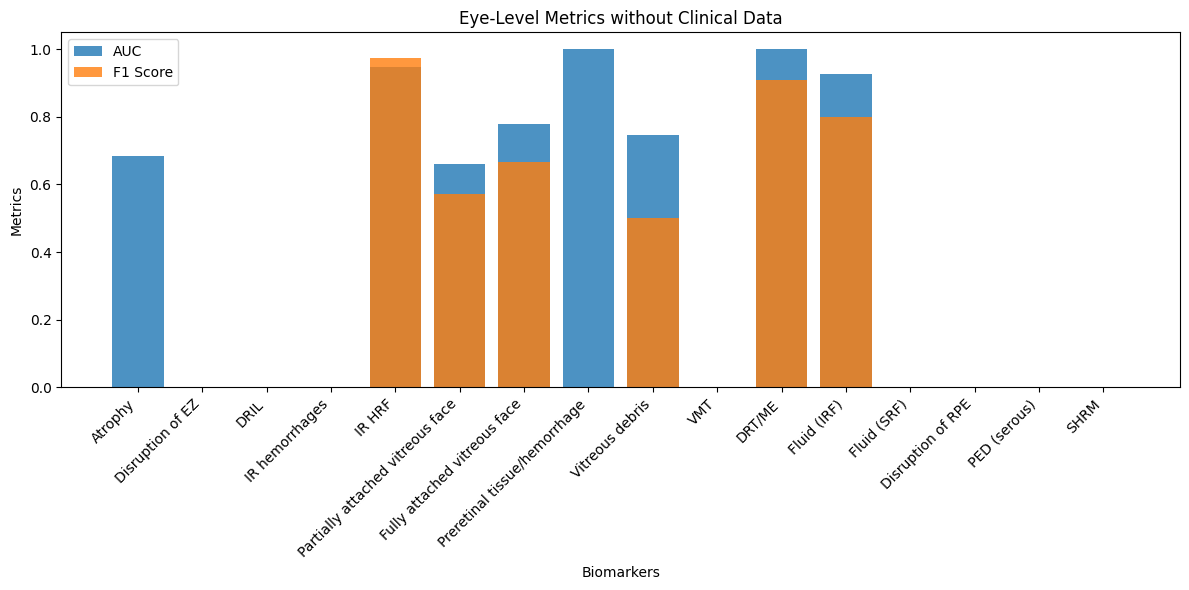


Ablation Study Results:
Clinical Data Impact on Biomarker Detection
                           Biomarker  F1 with Clinical Data
0                            Atrophy               0.000000
1                   Disruption of EZ               0.037383
2                               DRIL               0.000000
3                     IR hemorrhages               0.000000
4                             IR HRF               0.797218
5   Partially attached vitreous face               0.507736
6       Fully attached vitreous face               0.645487
7       Preretinal tissue/hemorrhage               0.112903
8                    Vitreous debris               0.446583
9                                VMT               0.000000
10                            DRT/ME               0.826418
11                       Fluid (IRF)               0.753153
12                       Fluid (SRF)               0.257143
13                 Disruption of RPE               0.000000
14                      PED (se

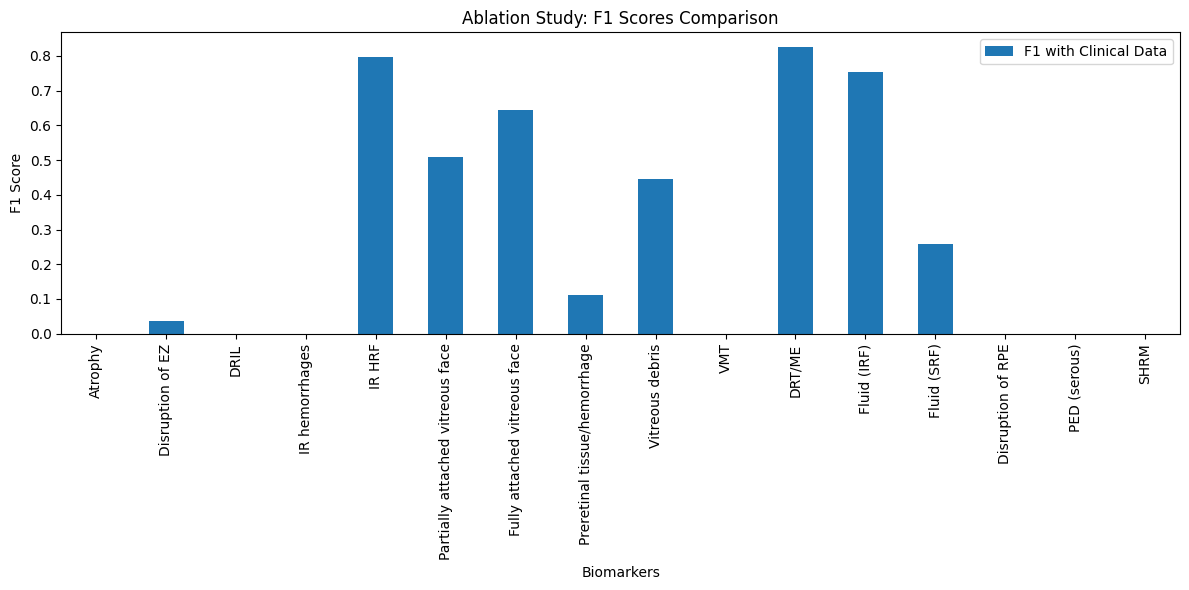

In [7]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# Evaluation Function
def evaluate_model(model, loader, labels):
    """
    Evaluate the model and calculate metrics at the scan level.
    """
    model.eval()
    y_true, y_pred, eye_ids = [], [], []
    with torch.no_grad():
        for images, labels, clinical_data in loader:
            images, labels, clinical_data = (
                images.to(device),
                labels.to(device),
                clinical_data.to(device),
            )
            outputs = model(images,clinical_data)
            y_true.append(labels.cpu().numpy())
            y_pred.append(outputs.cpu().numpy())
            if clinical_data.size(1) > 0:  # Ensure Eye_ID exists
                eye_ids.append(clinical_data[:, 0].cpu().numpy())
            else:
                eye_ids.append([])  # No Eye_ID if no clinical data
    return np.vstack(y_true), np.vstack(y_pred), np.concatenate(eye_ids)


# Function to compute weighted F1 score
def compute_weighted_f1(metrics_df, y_true):
    """
    Compute the weighted F1 score from metrics DataFrame and true labels.
    Args:
        metrics_df (DataFrame): DataFrame containing F1 scores for each biomarker.
        y_true (ndarray): Ground truth binary labels for all biomarkers.
    Returns:
        weighted_f1 (float): Weighted F1 score.
    """
    total_support = 0
    weighted_f1_sum = 0

    # Calculate support for each biomarker
    for i in range(len(metrics_df)):
        support = np.sum(y_true[:, i])  # Count of positive samples
        f1 = metrics_df.iloc[i]["F1"]
        weighted_f1_sum += f1 * support
        total_support += support

    # Handle division by zero in case total_support is 0
    if total_support == 0:
        return 0.0

    return weighted_f1_sum / total_support

# Updated Evaluation Function with Weighted F1 Computation
def evaluate_with_eye_aggregation(model, loader, labels, title_suffix=""):
    """
    Evaluate model and generate metrics.
    """
    print(f"Evaluating {title_suffix} Scan-Level Metrics...")
    y_true, y_pred, eye_ids = evaluate_model(model, loader, labels)

    scan_metrics = compute_metrics(y_true, y_pred, labels)
    macro_f1_scan = compute_macro_f1(scan_metrics)
    weighted_f1_scan = compute_weighted_f1(scan_metrics, y_true)
    print(f"Scan-Level Macro F1 {title_suffix}: {macro_f1_scan:.4f}")
    print(f"Scan-Level Weighted F1 {title_suffix}: {weighted_f1_scan:.4f}")

    if len(eye_ids) > 0:
        print(f"Evaluating {title_suffix} Eye-Level Metrics...")
        eye_true, eye_pred = aggregate_by_eye(y_true, y_pred, eye_ids)
        eye_metrics = compute_metrics(eye_true, eye_pred, labels)
        macro_f1_eye = compute_macro_f1(eye_metrics)
        weighted_f1_eye = compute_weighted_f1(eye_metrics, eye_true)
        print(f"Eye-Level Macro F1 {title_suffix}: {macro_f1_eye:.4f}")
        print(f"Eye-Level Weighted F1 {title_suffix}: {weighted_f1_eye:.4f}")
        return scan_metrics, macro_f1_scan, weighted_f1_scan, eye_metrics, macro_f1_eye, weighted_f1_eye

    return scan_metrics, macro_f1_scan, weighted_f1_scan, None, None, None

# Evaluate models with and without clinical data
print("Evaluating Model with Clinical Data...")
scan_metrics_clinical, macro_f1_scan_clinical, weighted_f1_scan_clinical, eye_metrics_clinical, macro_f1_eye_clinical, weighted_f1_eye_clinical = evaluate_with_eye_aggregation(
    model_clinical, testloader_clinical, labels, title_suffix="with Clinical Data"
)

print("Evaluating Model without Clinical Data...")
scan_metrics_no_clinical, macro_f1_scan_no_clinical, weighted_f1_scan_no_clinical, eye_metrics_no_clinical, macro_f1_eye_no_clinical, weighted_f1_eye_no_clinical = evaluate_with_eye_aggregation(
    model_no_clinical, testloader_no_clinical, labels, title_suffix="without Clinical Data"
)

# Print Results
print("\nFinal F1 Scores:")
print(f"Scan-Level Macro F1 with Clinical Data: {macro_f1_scan_clinical:.4f}")
print(f"Scan-Level Weighted F1 with Clinical Data: {weighted_f1_scan_clinical:.4f}")
print(f"Scan-Level Macro F1 without Clinical Data: {macro_f1_scan_no_clinical:.4f}")
print(f"Scan-Level Weighted F1 without Clinical Data: {weighted_f1_scan_no_clinical:.4f}")
if macro_f1_eye_clinical is not None and weighted_f1_eye_clinical is not None:
    print(f"Eye-Level Macro F1 with Clinical Data: {macro_f1_eye_clinical:.4f}")
    print(f"Eye-Level Weighted F1 with Clinical Data: {weighted_f1_eye_clinical:.4f}")
    print(f"Eye-Level Macro F1 without Clinical Data: {macro_f1_eye_no_clinical:.4f}")
    print(f"Eye-Level Weighted F1 without Clinical Data: {weighted_f1_eye_no_clinical:.4f}")

'''
# Aggregation Function for Eye-Level Metrics
def aggregate_by_eye(y_true, y_pred, eye_ids):
    """
    Aggregate predictions and labels at the eye level.
    """
    unique_eye_ids = np.unique(eye_ids)
    eye_level_true = []
    eye_level_pred = []
    for eye_id in unique_eye_ids:
        mask = eye_ids == eye_id
        eye_level_true.append(y_true[mask].mean(axis=0))
        eye_level_pred.append(y_pred[mask].mean(axis=0))
    return np.array(eye_level_true), np.array(eye_level_pred)'''


def compute_metrics(y_true, y_pred, labels):
    """
    Compute classification metrics for each biomarker.
    Args:
        y_true (ndarray or Tensor): True labels.
        y_pred (ndarray or Tensor): Predicted probabilities.
        labels (list): Biomarker names.
    Returns:
        metrics_df (DataFrame): DataFrame with per-biomarker metrics.
    """
    # Ensure tensors are moved to CPU and converted to NumPy
    if isinstance(y_true, torch.Tensor):
        y_true = y_true.cpu().numpy()
    if isinstance(y_pred, torch.Tensor):
        y_pred = y_pred.cpu().numpy()

    # Threshold y_true to ensure binary values
    y_true = (y_true > 0.5).astype(int)

    num_biomarkers = min(len(labels), y_true.shape[1])
    metrics = {"Biomarker": [], "AUC": [], "Precision": [], "Recall": [], "F1": []}

    for i in range(num_biomarkers):
        label = labels[i]

        # Check if y_true contains both classes
        if len(np.unique(y_true[:, i])) < 2:
            # Skip AUC calculation for constant labels
            metrics["Biomarker"].append(label)
            metrics["AUC"].append(None)  # Undefined AUC
            metrics["Precision"].append(0.0)
            metrics["Recall"].append(0.0)
            metrics["F1"].append(0.0)
            continue

        # Calculate metrics
        auc = roc_auc_score(y_true[:, i], y_pred[:, i])
        report = classification_report(
            y_true[:, i], (sigmoid(y_pred[:, i]) > 0.5).astype(int), output_dict=True, zero_division=0
        )
        metrics["Biomarker"].append(label)
        metrics["AUC"].append(auc)
        metrics["Precision"].append(report["1"]["precision"])
        metrics["Recall"].append(report["1"]["recall"])
        metrics["F1"].append(report["1"]["f1-score"])
    return pd.DataFrame(metrics)

# Plotting Metrics
def plot_metrics(metrics_df, title):
    """
    Plot metrics as bar plots.
    """
    plt.figure(figsize=(12, 6))
    x = range(len(metrics_df))
    plt.bar(x, metrics_df["AUC"], label="AUC", alpha=0.8)
    plt.bar(x, metrics_df["F1"], label="F1 Score", alpha=0.8)
    plt.xticks(x, metrics_df["Biomarker"], rotation=45, ha="right")
    plt.xlabel("Biomarkers")
    plt.ylabel("Metrics")
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()
    

# Plot ROC-AUC Curves
def plot_roc_auc_curves(y_true, y_pred, labels):
    plt.figure(figsize=(12, 8))
    for i, label in enumerate(labels):
        if len(np.unique(y_true[:, i])) < 2:
            continue  # Skip biomarkers with no positive samples
        fpr, tpr, _ = roc_curve(y_true[:, i], y_pred[:, i])
        plt.plot(fpr, tpr, label=f"{label} (AUC = {auc(fpr, tpr):.2f})")
    plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC-AUC Curves")
    plt.legend()
    plt.show()


from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Biomarker Labels
labels = [
    "Atrophy", "Disruption of EZ", "DRIL", "IR hemorrhages", "IR HRF",
    "Partially attached vitreous face", "Fully attached vitreous face",
    "Preretinal tissue/hemorrhage", "Vitreous debris", "VMT","DRT/ME", "Fluid (IRF)","Fluid (SRF)", "Disruption of RPE",
     "PED (serous)", "SHRM"
]

# Function to compute and plot a single confusion matrix for all biomarkers
def plot_combined_confusion_matrix(y_true, y_pred, title="Combined Confusion Matrix"):
    """
    Create and plot a single confusion matrix for all biomarkers.
    Args:
        y_true (ndarray): Ground truth binary labels for all biomarkers.
        y_pred (ndarray): Predicted probabilities for all biomarkers.
        title (str): Title for the confusion matrix plot.
    """
    # Flatten all biomarkers into a single dimension for combined confusion matrix
    y_true_combined = (y_true > 0.5).astype(int).ravel()  # Ensure binary labels
    # y_pred_combined = (y_pred > 0.5).astype(int).ravel()  # Threshold predictions
    y_pred_combined = (sigmoid(y_pred) > 0.5).astype(int).ravel()  # Threshold predictions

        
    # Compute confusion matrix
    combined_matrix = confusion_matrix(y_true_combined, y_pred_combined)

    # Plot the confusion matrix
    plt.figure(figsize=(6, 4))
    disp = ConfusionMatrixDisplay(confusion_matrix=combined_matrix, display_labels=["Negative", "Positive"])
    disp.plot(cmap="Blues", values_format="d")
    plt.title(title)
    plt.show()


# Update the evaluation function to include combined confusion matrix
# Evaluate and Aggregate Results
def evaluate_with_eye_aggregation(model, loader, labels):
    """
    Evaluate model performance with and without eye-level aggregation.
    """
    print("Evaluating Scan-Level Metrics...")
    y_true, y_pred, eye_ids = evaluate_model(model, loader, labels)

    # Compute combined confusion matrix for scan-level predictions
    print("Plotting Combined Confusion Matrix for Scan-Level Predictions...")
    plot_combined_confusion_matrix(y_true, y_pred, "Scan-Level Combined Confusion Matrix")

    # Scan-Level Metrics
    scan_metrics = compute_metrics(y_true, y_pred, labels)
    print(scan_metrics)

    # Eye-Level Metrics
    eye_metrics = None
    if len(eye_ids) > 0:
        print("Evaluating Eye-Level Metrics...")
        eye_true, eye_pred = aggregate_by_eye(y_true, y_pred, eye_ids)

        # Compute combined confusion matrix for eye-level predictions
        print("Plotting Combined Confusion Matrix for Eye-Level Predictions...")
        plot_combined_confusion_matrix(eye_true, eye_pred, "Eye-Level Combined Confusion Matrix")

        eye_metrics = compute_metrics(eye_true, eye_pred, labels)
        print(eye_metrics)

    return scan_metrics, eye_metrics


# Evaluate Models


print("Evaluating Model with Clinical Data...")
scan_metrics_clinical, eye_metrics_clinical = evaluate_with_eye_aggregation(
    model, testloader, labels
)

# Plot Results
plot_metrics(scan_metrics_clinical, "Scan-Level Metrics without Clinical Data")
if eye_metrics_clinical is not None:
    plot_metrics(eye_metrics_clinical, "Eye-Level Metrics without Clinical Data")

# Ablation Study
print("\nAblation Study Results:")
print("Clinical Data Impact on Biomarker Detection")
comparison = pd.DataFrame({
    "Biomarker": labels,
    "F1 with Clinical Data": scan_metrics_clinical["F1"],
    # "F1 with Clinical Data": scan_metrics_no_clinical["F1"],
})
print(comparison)
comparison.plot(x="Biomarker", kind="bar", figsize=(12, 6), title="Ablation Study: F1 Scores Comparison")
plt.xlabel("Biomarkers")
plt.ylabel("F1 Score")
plt.tight_layout()
plt.show()

In [12]:
import os
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from transformers import ViTForImageClassification
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
from tqdm import tqdm
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define BiomarkerDataset
class BiomarkerDataset(Dataset):
    def __init__(self, label_file, transform=None, num_frames=0, use_clinical=True):
        self.data = pd.read_csv(label_file)
        self.transform = transform
        self.num_frames = num_frames
        self.use_clinical = use_clinical
        self.valid_indices = self.data[
            (self.data.iloc[:, 1] > num_frames) & (self.data.iloc[:, 1] < (50 - num_frames))
        ].index.tolist()

    def __len__(self):
        return len(self.valid_indices)

    def __getitem__(self, idx):
        img_base_path = '/storage/ice1/shared/d-pace_community/makerspace-datasets/MEDICAL/OLIVES/OLIVES'
        index = self.valid_indices[idx]
        images = []

        for i in range(index - self.num_frames, index + self.num_frames + 1):
            img_path = img_base_path + self.data.iloc[i, 0]
            img = Image.open(img_path).convert("L")
            if self.transform is not None:
                img = self.transform(img)
            images.append(img.squeeze(0))

        images = torch.stack(images, dim=0)
        labels = torch.tensor(self.data.iloc[index, 2:18].astype(float), dtype=torch.float32)
        
        if self.use_clinical:
            clinical_data = torch.tensor(
                [self.data.iloc[index, 19], self.data.iloc[index, 20]], dtype=torch.float32
            )
        else:
            clinical_data = torch.tensor([], dtype=torch.float32)  # Empty clinical data

        return images, labels, clinical_data


# Define Multimodal Model
class MultimodalBiomarkerModel(nn.Module):
    def __init__(self, vision_model, clinical_input_size, num_biomarkers, use_clinical=True):
        super(MultimodalBiomarkerModel, self).__init__()
        self.vision_model = vision_model
        self.use_clinical = use_clinical
        if use_clinical:
            self.clinical_fc = nn.Linear(clinical_input_size, 128)
            self.combined_fc = nn.Linear(vision_model.config.hidden_size + 128, num_biomarkers)
        else:
            self.combined_fc = nn.Linear(vision_model.config.hidden_size, num_biomarkers)
        self.sigmoid = nn.Sigmoid()

    def forward(self, images, clinical_data):
        vision_features = self.vision_model(images).logits
        if self.use_clinical:
            clinical_features = torch.relu(self.clinical_fc(clinical_data))
            combined_features = torch.cat((vision_features, clinical_features), dim=1)
        else:
            combined_features = vision_features
        output = self.sigmoid(self.combined_fc(combined_features))
        return output


# Initialize Dataset and Transformers
image_size = 224
mean, std = 0.1706, 0.2112

# Train transform with data augmentation
train_transformer = transforms.Compose([
    transforms.Resize((image_size, image_size)),  # Resize to 224x224
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomRotation(degrees=10, fill=0),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

# Test transform without augmentation
test_transformer = transforms.Compose([
    transforms.Resize((image_size, image_size)),  # Resize to 224x224
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])


train_dataset_clinical = BiomarkerDataset('TEMP_BiomarkerLabel_train_data.csv', train_transformer, num_frames=1, use_clinical=True)
test_dataset_clinical = BiomarkerDataset('TEMP_BiomarkerLabel_test_data.csv', test_transformer, num_frames=1, use_clinical=True)

train_dataset_no_clinical = BiomarkerDataset('TEMP_BiomarkerLabel_train_data.csv', train_transformer, num_frames=1, use_clinical=False)
test_dataset_no_clinical = BiomarkerDataset('TEMP_BiomarkerLabel_test_data.csv', test_transformer, num_frames=1, use_clinical=False)

trainloader_clinical = DataLoader(train_dataset_clinical, batch_size=64, shuffle=True, drop_last=True)
testloader_clinical = DataLoader(test_dataset_clinical, batch_size=64, shuffle=False)

trainloader_no_clinical = DataLoader(train_dataset_no_clinical, batch_size=64, shuffle=True, drop_last=True)
testloader_no_clinical = DataLoader(test_dataset_no_clinical, batch_size=64, shuffle=False)


# Load trained models
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vision_model = ViTForImageClassification.from_pretrained(
    "google/vit-base-patch16-224", num_labels=16, ignore_mismatched_sizes=True
)
vision_model.classifier = nn.Identity()

# Load models with and without clinical data
model_clinical = MultimodalBiomarkerModel(vision_model, clinical_input_size=2, num_biomarkers=16, use_clinical=True).to(device)
model_no_clinical = MultimodalBiomarkerModel(vision_model, clinical_input_size=2, num_biomarkers=16, use_clinical=False).to(device)
model_clinical.load_state_dict(torch.load("best_model_clinical.pth"))
model_no_clinical.load_state_dict(torch.load("best_model_no_clinical.pth"))

# Define target layer and Grad-CAM
target_layer = "vision_model.vit.encoder.layer.8.output"  # Change based on your ViT architecture


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([16]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([16, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


**GRAD CAM Analysis with and without Clinical Data**

Random index: 345


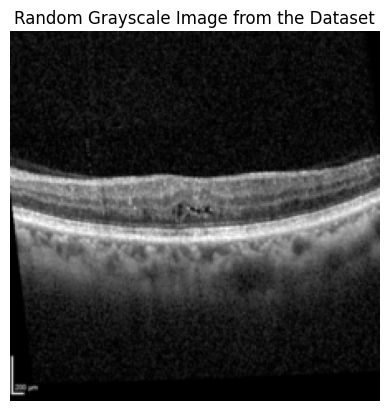

Grad-CAM for MultimodalBiomarkerModel


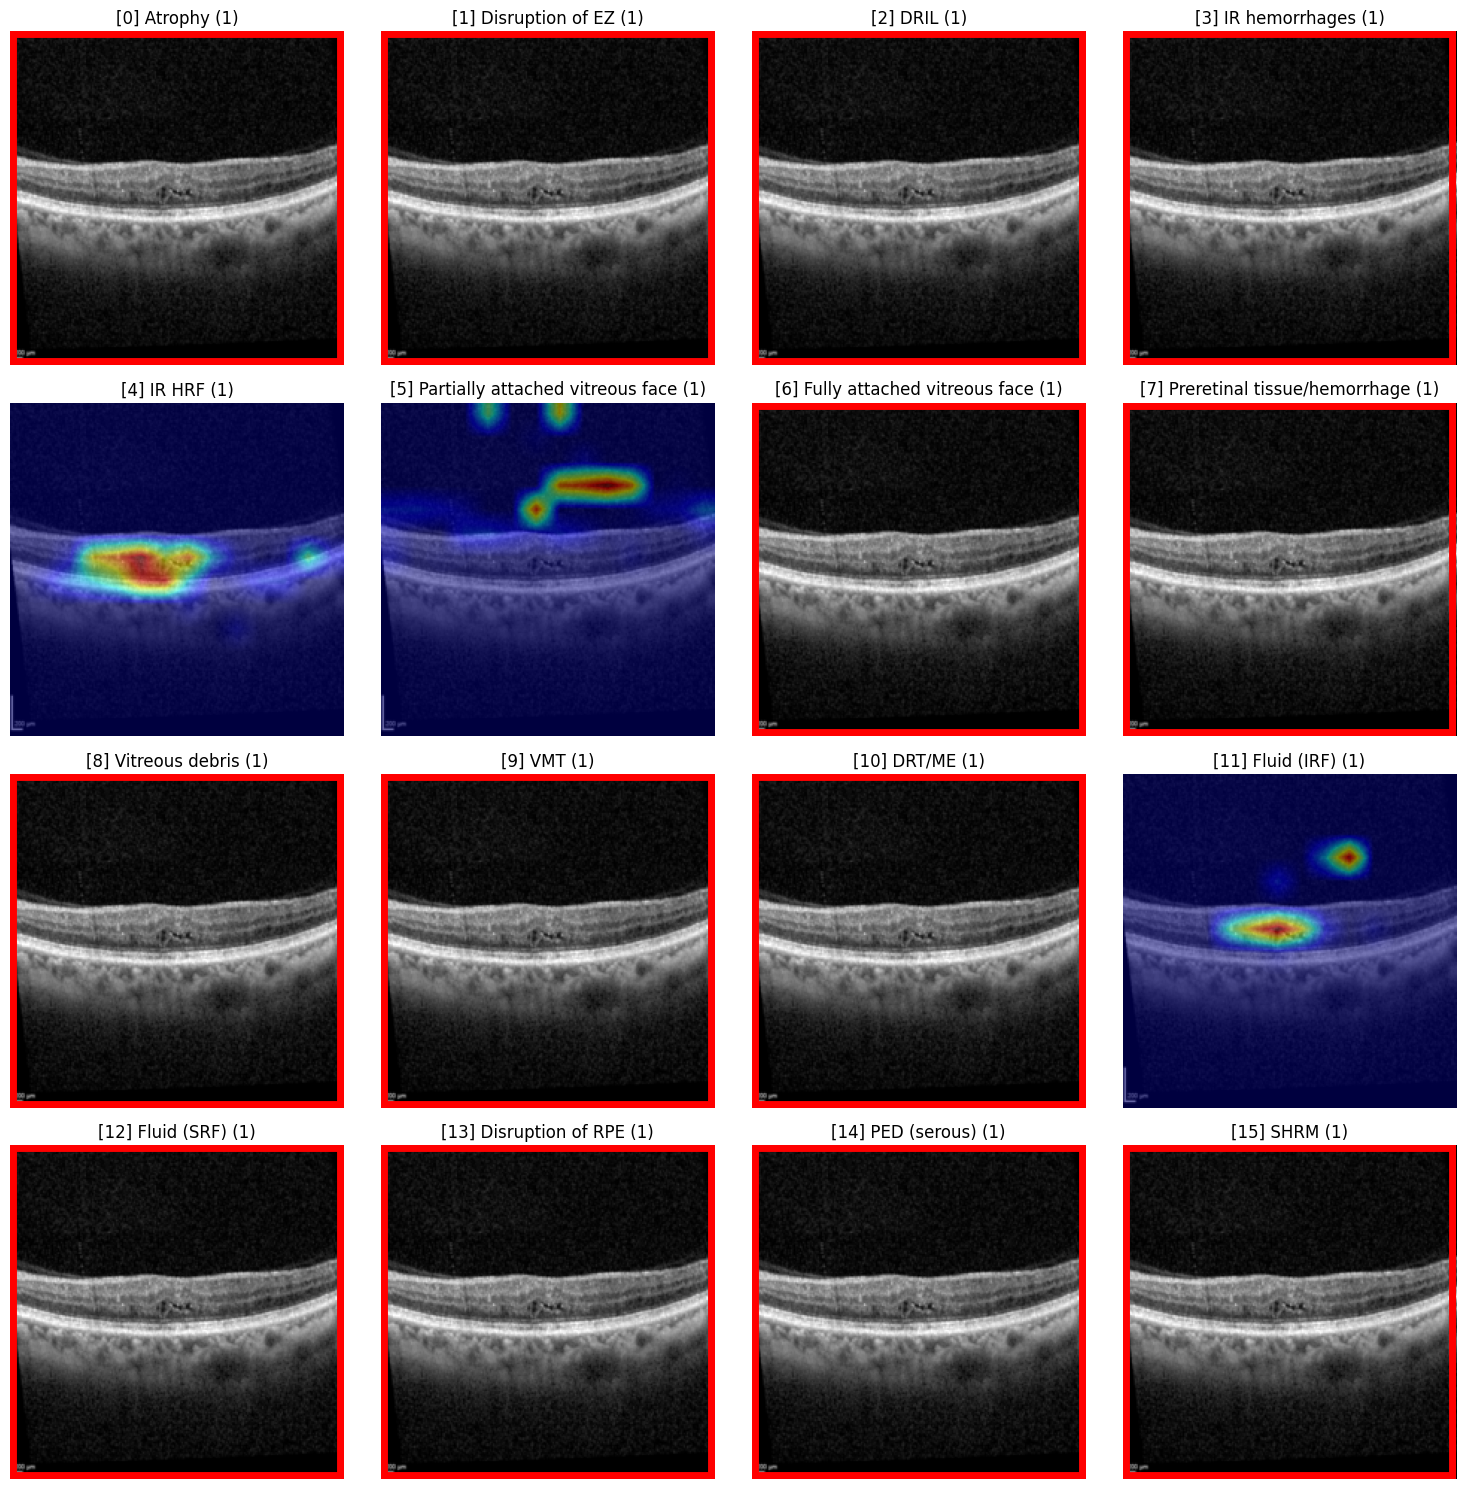

Grad-CAM for MultimodalBiomarkerModel


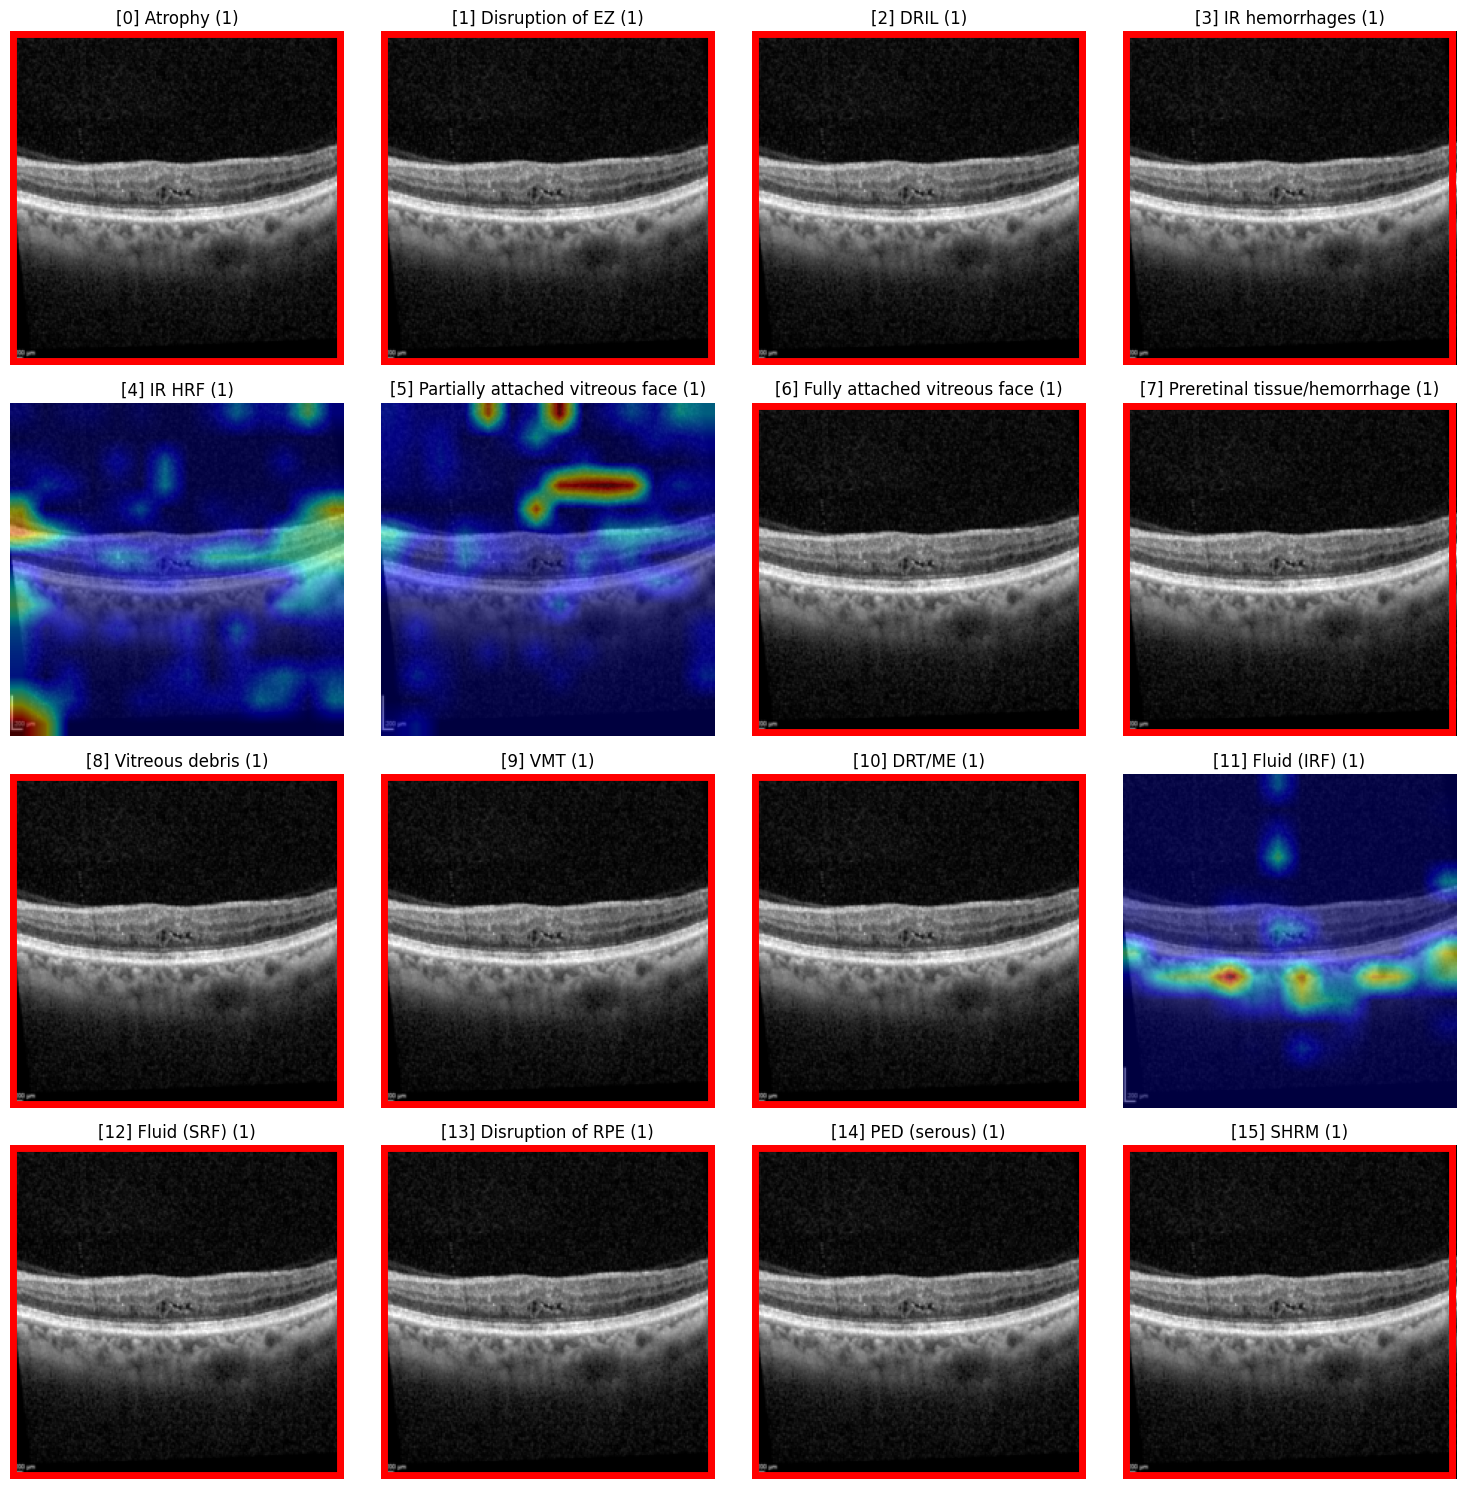

In [34]:
import os
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from transformers import ViTForImageClassification
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import classification_report, confusion_matrix
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch.nn.functional as F
from matplotlib.patches import Rectangle
import random

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Biomarker Labels
BiomarkerLabels = [
    "Atrophy", "Disruption of EZ", "DRIL", "IR hemorrhages", "IR HRF",
    "Partially attached vitreous face", "Fully attached vitreous face",
    "Preretinal tissue/hemorrhage", "Vitreous debris", "VMT", "DRT/ME", "Fluid (IRF)",
    "Fluid (SRF)", "Disruption of RPE", "PED (serous)", "SHRM"
]

# Control Grad-CAM visualization
show_all_gradCAM = 0  # Set to 1 to display all Grad-CAM maps

# Biomarker Dataset
class BiomarkerDataset(Dataset):
    def __init__(self, label_file, transform=None, num_frames=0, use_clinical=True):
        self.data = pd.read_csv(label_file)
        self.transform = transform
        self.num_frames = num_frames
        self.use_clinical = use_clinical
        self.valid_indices = self.data[
            (self.data.iloc[:, 1] > num_frames) & (self.data.iloc[:, 1] < (50 - num_frames))
        ].index.tolist()

    def __len__(self):
        return len(self.valid_indices)

    def __getitem__(self, idx):
        img_base_path = '/storage/ice1/shared/d-pace_community/makerspace-datasets/MEDICAL/OLIVES/OLIVES'
        index = self.valid_indices[idx]
        images = []

        for i in range(index - self.num_frames, index + self.num_frames + 1):
            img_path = os.path.join(img_base_path, self.data.iloc[i, 0])
            img = Image.open(img_path).convert("L")
            if self.transform is not None:
                img = self.transform(img)
            images.append(img.squeeze(0))

        images = torch.stack(images, dim=0)
        labels = torch.tensor(self.data.iloc[index, 2:18].astype(float), dtype=torch.float32)

        if self.use_clinical:
            clinical_data = torch.tensor(
                [self.data.iloc[index, 19], self.data.iloc[index, 20]], dtype=torch.float32
            )
        else:
            clinical_data = torch.tensor([], dtype=torch.float32)

        return images, labels, clinical_data


# Multimodal Model
class MultimodalBiomarkerModel(nn.Module):
    def __init__(self, vision_model, clinical_input_size, num_biomarkers, use_clinical=True):
        super(MultimodalBiomarkerModel, self).__init__()
        self.vision_model = vision_model
        self.use_clinical = use_clinical
        if use_clinical:
            self.clinical_fc = nn.Linear(clinical_input_size, 128)
            self.combined_fc = nn.Linear(vision_model.config.hidden_size + 128, num_biomarkers)
        else:
            self.combined_fc = nn.Linear(vision_model.config.hidden_size, num_biomarkers)
        self.sigmoid = nn.Sigmoid()

    def forward(self, images, clinical_data):
        vision_features = self.vision_model(pixel_values=images).logits
        if self.use_clinical:
            clinical_features = torch.relu(self.clinical_fc(clinical_data))
            combined_features = torch.cat((vision_features, clinical_features), dim=1)
        else:
            combined_features = vision_features
        output = self.sigmoid(self.combined_fc(combined_features))
        return output



class GradCAM:
    def __init__(self, model_object, target_layer_name):
        """
        Args:
            model_object: Pretrained model (e.g., Vision Transformer).
            target_layer_name: String name of the specific layer to hook.
        """
        self.model = model_object
        self.gradients = {}
        self.activations = {}

        # Resolve the layer dynamically
        target_layer = self._get_layer_by_name(self.model, target_layer_name)

        # Register hooks
        def backward_hook(module, grad_input, grad_output):
            self.gradients["value"] = grad_output[0]
            return None

        def forward_hook(module, input, output):
            self.activations["value"] = output
            return None

        target_layer.register_forward_hook(forward_hook)
        target_layer.register_full_backward_hook(backward_hook)

    def _get_layer_by_name(self, model, layer_name):
        """
        Retrieves a layer in the model based on its string name.
        """
        layers = layer_name.split(".")
        layer = model
        for l in layers:
            if "[" in l and "]" in l:
                # Handle indexing in lists, e.g., 'layer4[2]'
                layer_name, idx = l[:-1].split("[")
                layer = getattr(layer, layer_name)[int(idx)]
            else:
                layer = getattr(layer, l)
        return layer

    def calculate(self, input_tensor, class_idx, clinical_data=None):
        """
        Args:
            input_tensor: Input image (1, 3, H, W).
            class_idx: Index of the biomarker to compute Grad-CAM for.
            clinical_data: Optional, additional clinical data to pass to the model.

        Returns:
            saliency_map: Grad-CAM saliency map (H, W).
        """
        self.model.eval()
        input_tensor = input_tensor.to(device)

        # Forward pass
        if clinical_data is not None:
            logit = self.model(input_tensor, clinical_data)
        else:
            logit = self.model(input_tensor)

        target_logit = logit[:, class_idx]

        # Backward pass
        self.model.zero_grad()
        target_logit.backward(retain_graph=True)

        # Grad-CAM computation
        gradients = self.gradients["value"]  # Shape: [batch_size, num_patches + 1, hidden_dim]
        activations = self.activations["value"]  # Shape: [batch_size, num_patches + 1, hidden_dim]

        # Exclude CLS token
        gradients = gradients[:, 1:, :]  # Remove CLS token gradient
        activations = activations[:, 1:, :]  # Remove CLS token activation

        # Compute weights (global average pooling over patches)
        weights = torch.mean(gradients, dim=1)  # Shape: [batch_size, hidden_dim]

        # Compute Grad-CAM
        cam = torch.einsum("bpd,bd->bp", activations, weights)  # Shape: [batch_size, num_patches]
        cam = F.relu(cam)

        # Reshape CAM to match the original spatial layout
        num_patches = int(cam.size(1)**0.5)
        cam = cam.view(input_tensor.size(0), num_patches, num_patches)

        # Upsample CAM to match input image dimensions
        cam = F.interpolate(cam.unsqueeze(1), size=(224, 224), mode="bilinear", align_corners=False).squeeze()

        # Normalize the saliency map
        cam_min, cam_max = cam.min(), cam.max()
        saliency_map = (cam - cam_min) / (cam_max - cam_min + 1e-8)

        # Get prediction
        prediction = (torch.sigmoid(target_logit) > 0.5).int().cpu().numpy()

        return saliency_map.cpu(), prediction


# Update the target layer
target_layer = "vision_model.vit.encoder.layer.8.output"


# Pick a random index from the dataset
random_index = random.randint(0, len(test_dataset_clinical) - 1)
# optional overwrite the index
# random_index = 2193
# random_index = 1387
print(f"Random index: {random_index}")

# Fetch the sample
images, labels, clinical_data = test_dataset_clinical[random_index]

# Undo normalization for visualization of grayscale channel
grayscale_image = images[1].cpu().numpy() * std + mean  # Grayscale for visualization

# Plot the grayscale image
plt.imshow(grayscale_image, cmap='gray')
plt.title("Random Grayscale Image from the Dataset")
plt.axis('off')
plt.show()

# Prepare the image (3-channel) for input to the model
input_image = images.unsqueeze(0).to(device)  # Add batch dimension, move to device
clinical_data = clinical_data.unsqueeze(0).to(device)

# Define the models and target layers
# ([Model], [Target Layer], [Show grad-CAM for all biomarkers (0 is only for detected)])
GradCamVisInput = [
    (model_no_clinical, target_layer, 0),  # ImageModel.layer4[2].conv2
    (model_clinical, target_layer, 0)
]

# Loop through each model
for model, target_layer, show_all_gradCAM in GradCamVisInput:
    # Initialize Grad-CAM
    gradcam = GradCAM(model, target_layer)
    
    # Grad-CAM for biomarkers
    gradcam_maps = []
    pred_map = []
    for biomarker_idx in range(16):
        saliency_map, pred_singleBiomarker = gradcam.calculate(input_image, biomarker_idx, clinical_data=clinical_data)
        gradcam_maps.append(saliency_map.cpu().detach().numpy())
        pred_map.append(pred_singleBiomarker)
    
    # Print which model is being processed
    print(f"Grad-CAM for {model.__class__.__name__}")
    
    # Plot the Grad-CAM maps for all biomarkers
    fig, axes = plt.subplots(4, 4, figsize=(15, 15))
    axes = axes.flatten()
    
    for i, ax in enumerate(axes):
        # If the Grad-CAM map is not zero (meaning the biomarker was detected)
        if labels[i] > 0.5 or show_all_gradCAM > 0:
            heatmap = gradcam_maps[i]
            ax.imshow(grayscale_image, cmap="gray")
            ax.imshow(heatmap, cmap="jet", alpha=0.5)  # Overlay heatmap
        else:
            # If no biomarker is detected, just show the grayscale image
            ax.imshow(grayscale_image, cmap="gray")
        
        # Set the title with the biomarker name and index
        ax.set_title(f"[{i}] {BiomarkerLabels[i]} ({int(pred_map[i])})")
        ax.axis("off")
        
        # Add a red box if prediction is wrong
        if labels[i] != int(pred_map[i]):
            # Add a red rectangle around the axes
            rect = Rectangle((0, 0), 1, 1, transform=ax.transAxes, color='red', linewidth=10, fill=False)
            ax.add_patch(rect)
    
    plt.tight_layout()
    plt.show()
